In [91]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# Verified Neural System Identification and Control

This notebook contains some exploratory code, directed towards the problem of 

1. learning the dynamics of a discrete-time dynamical system,
2. learning (simultaneously) a stabilizing controller for the system and a Lyapunov stability certificate, and
3. verifying that the Lyapunov property holds despite some bounded error in system identification

## Theory

Consider a discrete-time dynamical system $x_{t+1} = f(x_t, u_t)$, where $x \in \mathcal{X} \subset \mathbb{R}^n$ and $u \in \mathcal{U} \subset \mathbb{R}^m$, equipped with a feedback controller $u = \pi(x)$. This gives us the closed-loop dynamics $$x_{t+1} = f(x_t, \pi(x_t)) = f_\pi(x_t)$$

Assume the closed-loop system has a fixed point $x^*$ such that $f_\pi(x^*) = x^*$. Let $V(x): \mathbb{R}^n \to \mathbb{R}$. Then the closed loop system will be asymptotically stable at $x^*$ if the following hold:

1. $V(x^*) = 0$
2. $V(x) > 0;\quad \forall x \in (\mathcal{X} - x^*)$
3. $V(x_{t+1}) - V(x_t) < 0;\quad \forall x \in (\mathcal{X} - x^*)$

We can also express (3) in terms of the closed-loop dynamics: $V\circ f_\pi(x_t) - V(x_t) < 0$.

## Approach

We will approach this problem in three steps.

1. First, we will learn the open-loop system dynamics $f(x, u)$ from trajectories, using a neural network with ReLU activations.
2. Next, we will fix the learned dynamics and simultaneously learn a controller $\pi(x)$ and Lyapunov function $V(x)$, using a loss that guides us towards satisfying conditions (1)-(3) above.
3. Finally, we will verify that conditions (2) and (3) hold throughout the domain.

## Step 1: Learn dynamics from trajectories

We'll use a Dubins car model here and try to learn the dynamics (I tried an acrobot model and it was too hard, so I'm starting with this easier model instead).

In [153]:
# Start by building an oracle for the system dynamics. This will be used to generate training trajectories
def f_true(x, u):
    """Acrobot discrete-time dynamics.
    Source: http://underactuated.mit.edu/acrobot.html#section1
    """
    # Define parameters
    dt = 0.1  # timestep
    v = 0.5    # forward speed of the car
    
    # Unpack state variables
    assert x.shape == (3, 1)  # x, y, theta
    assert u.shape == (1, 1)
    
    # Construct the derivatives
    xdot = np.zeros(x.shape)
    # First derivatives of x, y, and theta
    xdot[0, 0] = v*np.cos(x[2, 0])
    xdot[1, 0] = v*np.sin(x[2, 0])
    xdot[2, 0] = u[0, 0]
    
    # Apply a simple euler integration to advance the dynamics
    new_x = np.copy(x)
    new_x += xdot * dt
    
    return new_x


In [154]:
# Gather training and test data by sampling directly from the joint state/action space
# We'll use the test data to characterize the error in the learned dynamics.
N_train = 1000000
N_test = 200000

x_min = np.zeros((3, 1))
x_min[0, 0] = -10
x_min[1, 0] = -10
x_min[2, 0] = -np.pi
x_max = -1 * x_min
u_max = np.array([[20]])
u_min = -u_max

sample_min = np.concatenate((x_min, u_min))
sample_max = np.concatenate((x_max, u_max))

x_train = np.random.uniform(sample_min, sample_max, (4, N_train)).transpose()
x_test = np.random.uniform(sample_min, sample_max, (4, N_test)).transpose()

f_train = np.zeros((N_train, 3))
for i, x in enumerate(x_train):
    f_train[i, :] = f_true(x[:3].reshape(3, 1), x[-1].reshape(1, 1)).reshape(3,)
f_test = np.zeros((N_test, 3))
for i, x in enumerate(x_test):
    f_test[i, :] = f_true(x[:3].reshape(3, 1), x[-1].reshape(1, 1)).reshape(3,)

In [155]:
# Convert trajectories to torch tensors
x_train_torch = torch.from_numpy(x_train).float()
x_test_torch = torch.from_numpy(x_test).float()
f_train_torch = torch.from_numpy(f_train).float()
f_test_torch = torch.from_numpy(f_test).float()

In [177]:
# Define the network for learning the dynamics
n_hidden_layers = 2
hidden_layer_size = 128

n_dims = 3
n_controls = 1

layers = []
# Input layer: inputs are states and controls, outputs are hidden layer activations
input_layer = [nn.Linear(n_dims + n_controls, hidden_layer_size), nn.ReLU()]
layers = layers + input_layer
# Hidden layers: inputs and outputs are the same size
for i in range(n_hidden_layers - 1):
    hidden_layer = [nn.Linear(hidden_layer_size, hidden_layer_size), nn.ReLU()]
    layers = layers + hidden_layer
# Output layer: outputs new states
layers = layers + [nn.Linear(hidden_layer_size, n_dims)]

# Build the network from these components
dynamics_model = nn.Sequential(*layers)
dynamics_model

# Train the dynamics model!

# Define hyperparameters for the learning process
learning_rate = 5e-4
batch_size = 1024
max_epochs = 1000

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = learning_rate * (0.1 ** (epoch // 50))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Define the loss function
loss_fn = nn.L1Loss()

# Train the IK network
optimizer = optim.Adam(dynamics_model.parameters(), lr=learning_rate)

# Also log histories of training and test loss
training_losses = []
test_losses = []
best_loss = np.inf

epochs = tqdm(range(max_epochs))
for epoch in epochs:
    # Set the adaptive learning rate
    adjust_learning_rate(optimizer, epoch)
    
    # Randomize the presentation order in each epoch
    permutation = torch.randperm(N_train)
    
    loss_acumulated = 0.0
    for i in range(0, N_train, batch_size):
        # Get input/output pairs
        indices = permutation[i:i+batch_size]
        state_control_pairs = x_train_torch[indices]
        next_state = f_train_torch[indices]
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        predicted_next_state = dynamics_model(state_control_pairs)
        
        # Compute loss and backpropagate
        loss = loss_fn(predicted_next_state, next_state)
        loss += torch.max(torch.norm(predicted_next_state - next_state, dim=1))
        loss_acumulated += loss.item()
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    # save progress
    training_losses.append(loss_acumulated / (N_train / batch_size))
    
    # Reset accumulated loss and get loss for the test set
    loss_acumulated = 0.0
    with torch.no_grad():
        # Get input/output pairs
        state_control_pairs = x_test_torch
        next_state = f_test_torch

        predicted_next_state = dynamics_model(state_control_pairs)

        loss = loss_fn(predicted_next_state, next_state)
        loss += torch.max(torch.norm(predicted_next_state - next_state, dim=1))
        test_losses.append(loss)
        epochs.set_description(f"Test loss: {round(loss.item(), 4)}")
        
        if loss <= best_loss:
            best_loss = loss
            filename = 'logs/dubins_model_best.pth.tar'
            torch.save({'n_hidden_layers':n_hidden_layers, 'neurons_per_layer':hidden_layer_size, 'dynamics_model': dynamics_model.state_dict()}, filename)

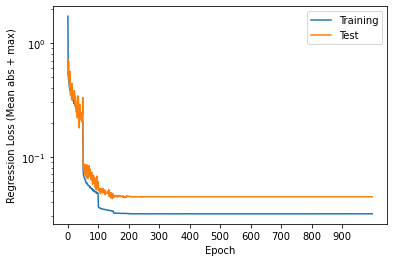

In [179]:
# Plot the loss curves
plt.plot(range(epoch+1), training_losses)
plt.plot(range(epoch+1), test_losses)
plt.gca().set_xticks(np.arange(0, epoch+1, 100))
plt.xlabel("Epoch")
plt.ylabel("Regression Loss (Mean abs + max)")
plt.legend(["Training", "Test"])
plt.yscale("log")

In [180]:
loss_acumulated = 0.0
with torch.no_grad():
    # Get input/output pairs
    state_control_pairs = x_test_torch
    next_state = f_test_torch

    predicted_next_state = dynamics_model(state_control_pairs)

    loss = loss_fn(predicted_next_state, next_state)
    print(f"Test loss (mean L1): {round(loss.item(), 4)}")
    loss = torch.max(torch.abs(predicted_next_state - next_state))
    print(f"Test loss (max L1): {round(loss.item(), 4)}")
    loss = torch.max(torch.norm(predicted_next_state - next_state, dim=1))
    print(f"Test loss (max L2): {round(loss.item(), 4)}")

Test loss (mean L1): 0.0055
Test loss (max L1): 0.0317
Test loss (max L2): 0.0392
